In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import copy

# --------------------------
# Tic Tac Toe Environment
# --------------------------

class TicTacToe:
    """
    Simulates the game board and rules.
    I'll represent the board as a flattended 1D array of 9 integers.
    It's easier to manage index 0-8 than [0][0] to [2][2].
    """
    def __init__(self):
        # 0 = empty, 1 = Player X, -1 = Player O
        self.board = np.zeros(9, dtype=int) 
        self.winner = None
        self.game_over = False
        
    def reset(self):
        # We need this to start a fresh game.
        # Just zero out the board and reset flags.
        self.board = np.zeros(9, dtype=int)
        self.winner = None
        self.game_over = False
        return self.get_state()
    
    def get_state(self):
        # I need a way to store the board state in a dictionary (hash map).
        # Numpy arrays aren't hashable (because they are mutable), but tuples are.
        # So, I'll convert the board to a tuple before returning it.
        # Example: (0, 0, 1, -1, 0, ...)
        return tuple(self.board)
    
    def available_actions(self):
        # Simply find indices where the board is 0 (empty).
        # np.where returns a tuple, so I take the first element [0].
        return np.where(self.board == 0)[0]
    
    def step(self, action, player):
        """
        The core game logic.
        1. Apply the move.
        2. Check if the game ended (Win or Draw).
        3. Return the new state, reward, and done flag.
        """
        if self.board[action] != 0:
            raise ValueError("Invalid move: spot is already taken.")
        
        self.board[action] = player
        
        # --- Check Win Conditions ---
        # I'll check rows, columns, and diagonals manually.
        # Since I use 1 for X and -1 for O, a sum of 3 means X won, -3 means O won.
        
        # Check Rows (0-2, 3-5, 6-8)
        for i in range(0, 9, 3):
            if abs(sum(self.board[i:i+3])) == 3: 
                self.winner = player
                self.game_over = True
                return self.get_state(), self.get_reward(player), True
        
        # Check Columns (0,3,6... 1,4,7... 2,5,8)
        for i in range(3):
            if abs(sum(self.board[i::3])) == 3:
                self.winner = player
                self.game_over = True
                return self.get_state(), self.get_reward(player), True
                
        # Check Diagonals
        # [0, 4, 8] is top-left to bottom-right
        # [2, 4, 6] is top-right to bottom-left
        if abs(sum(self.board[[0, 4, 8]])) == 3 or abs(sum(self.board[[2, 4, 6]])) == 3:
            self.winner = player
            self.game_over = True
            return self.get_state(), self.get_reward(player), True
            
        # --- Check Draw ---
        # If no one won, but there are no empty spots left, it's a draw.
        if len(self.available_actions()) == 0:
            self.game_over = True
            return self.get_state(), 0, True 
            
        # The game continues...
        return self.get_state(), 0, False

    def get_reward(self, player):
        # Defining the reward signal for the RL agent.
        # Win = +1
        # Loss = -1 (This helps the agent realize losing is bad)
        # Draw/Ongoing = 0
        if self.winner == player:
            return 1
        elif self.winner == -player: 
            return -1 
        elif self.winner is None:
            return 0
        return 0

# --------------------------
# Minimax Solved Game (The Oracle)
# --------------------------

# I want to measure if the agent is actually learning optimal play.
# Since Tic-Tac-Toe is solvable, I can write a Minimax algorithm to find the PERFECT move.
# I'll use this to compare the agent's move against the perfect move later.

memo_opt = {} # Memoization cache to speed up recursive calls.

def minimax(board, player, is_maximizing):
    """
    Standard Minimax recursion.
    is_maximizing = True means it's 'player's turn, we want to maximize score.
    is_maximizing = False means it's opponent's turn, they want to minimize our score.
    """
    
    # 1. Base Case: Check if game is over (Win/Loss)
    # I return 10 or -10 to make wins/losses distinct from draws (0).
    for i in range(0, 9, 3):
        if abs(sum(board[i:i+3])) == 3: return (1 if board[i] == player else -1) * (10)
    for i in range(3):
        if abs(sum(board[i::3])) == 3: return (1 if board[i] == player else -1) * (10)
    if abs(sum(board[[0, 4, 8]])) == 3: return (1 if board[0] == player else -1) * (10)
    if abs(sum(board[[2, 4, 6]])) == 3: return (1 if board[2] == player else -1) * (10)
    
    # Check Draw
    avail = [i for i, x in enumerate(board) if x == 0]
    if not avail: return 0 

    # 2. Recursive Step
    if is_maximizing:
        best_score = -float('inf')
        for a in avail:
            board[a] = player      # Try move
            score = minimax(board, player, False) # Recurse for opponent
            board[a] = 0           # Undo move (backtracking)
            best_score = max(score, best_score)
        return best_score
    else:
        best_score = float('inf')
        opponent = -player
        for a in avail:
            board[a] = opponent
            score = minimax(board, player, True)
            board[a] = 0 
            best_score = min(score, best_score)
        return best_score

def get_optimal_actions(board_tuple, player):
    # Wrapper around minimax to get ALL optimal moves for a given state.
    # Returns a list of indices (e.g., [0, 4] means corners and center are best).
    
    if board_tuple in memo_opt:
        return memo_opt[board_tuple]
    
    board = np.array(board_tuple)
    avail = [i for i, x in enumerate(board) if x == 0]
    
    action_values = []
    
    # For every possible move, simulate it and run minimax on the result.
    for a in avail:
        board[a] = player
        val = minimax(board, player, False) 
        board[a] = 0
        action_values.append((a, val))
        
    if not action_values:
        return []
        
    # Find the moves that resulted in the highest minimax score.
    max_val = max(v for k, v in action_values)
    best_actions = [k for k, v in action_values if v == max_val]
    
    memo_opt[board_tuple] = best_actions
    return best_actions

# --------------------------
# RL Agent (Q-Learning)
# --------------------------

class Agent:
    def __init__(self, epsilon=0.1, alpha=0.5, gamma=1.0):
        # The Q-Table: Maps state (board tuple) -> Array of 9 Q-values.
        # This is where the "knowledge" is stored.
        self.q_table = {} 
        self.epsilon = epsilon 
        self.alpha = alpha     # Learning rate (how fast we update values)
        self.gamma = gamma     # Discount factor (how much we care about future rewards)
        self.prev_state = None
        self.prev_action = None
        
    def get_q(self, state):
        # If we encounter a state we've never seen, initialize it with zeros.
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        return self.q_table[state]
    
    def choose_action(self, state, available_actions):
        # Epsilon-Greedy Policy:
        # Sometimes explore (random), sometimes exploit (greedy).
        
        if np.random.random() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            q_values = self.get_q(state)
            
            # Mask out invalid moves so we don't pick an occupied spot.
            # Setting them to -infinity ensures they are never the max.
            mask_q = np.full(9, -np.inf)
            mask_q[available_actions] = q_values[available_actions]
            
            # Find max Q-value
            max_val = np.max(mask_q)
            
            # There might be multiple best moves with the same value.
            # Randomly choose among them to avoid bias.
            best_actions = np.where(mask_q == max_val)[0]
            return np.random.choice(best_actions)

    def learn(self, current_state, reward, done, available_actions):
        """
        We update the Q-value of the previous state-action pair based on:
        1. The immediate reward we just got.
        2. The estimated value of the state we just landed in (current_state).
        """
        if self.prev_state is None:
            return

        # Estimate of future value (max Q of current state)
        q_values_next = self.get_q(current_state)
        # If terminal, future value is 0. Otherwise, take max of available actions.
        max_q_next = 0 if done else np.max(q_values_next[available_actions]) if len(available_actions) > 0 else 0
        
        # Current faulty estimate
        old_val = self.q_table[self.prev_state][self.prev_action]
        
        # Apply the formula
        # Q(s,a) = Q(s,a) + alpha * [reward + gamma * max(Q(s')) - Q(s,a)]
        self.q_table[self.prev_state][self.prev_action] = old_val + self.alpha * (reward + self.gamma * max_q_next - old_val)


Starting Experiment: 100 Time-steps
Running for epsilon=0 | Steps: 100 | Games/Step: 2000


Eps 0: 100%|██████████| 100/100 [02:28<00:00,  1.49s/it]


Running for epsilon=0.1 | Steps: 100 | Games/Step: 2000


Eps 0.1: 100%|██████████| 100/100 [01:28<00:00,  1.13it/s]


Running for epsilon=0.01 | Steps: 100 | Games/Step: 2000


Eps 0.01: 100%|██████████| 100/100 [01:27<00:00,  1.14it/s]


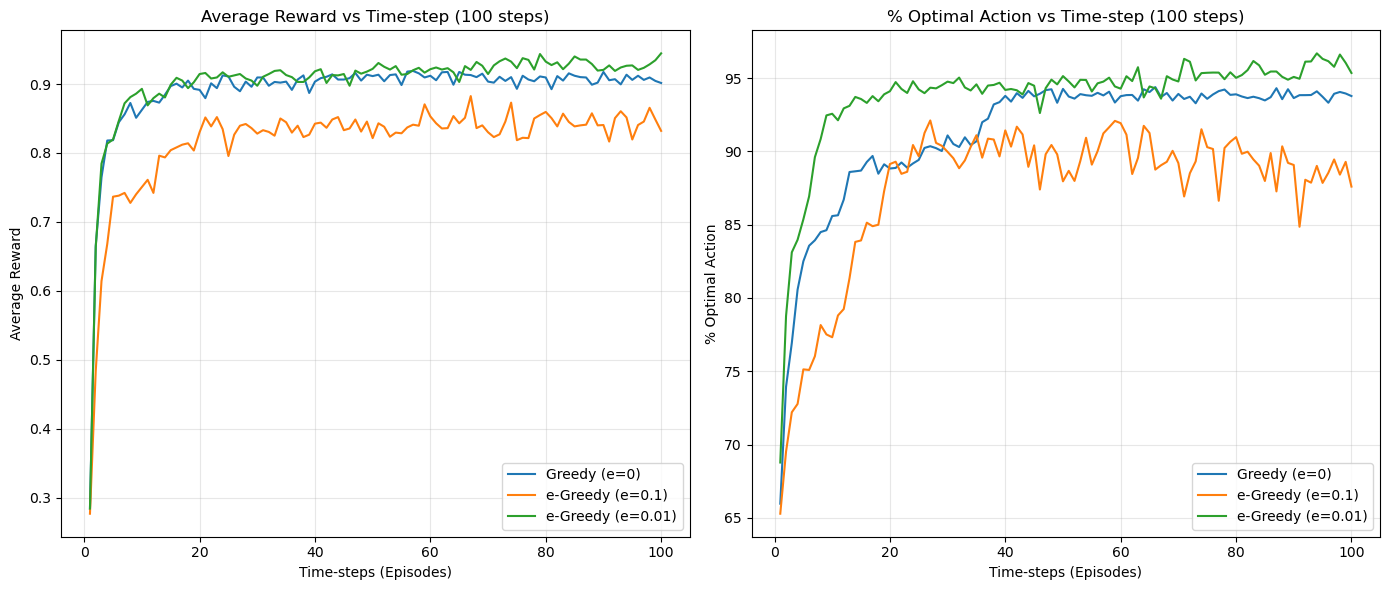


Starting Experiment: 200 Time-steps
Running for epsilon=0 | Steps: 200 | Games/Step: 2000


Eps 0: 100%|██████████| 200/200 [03:06<00:00,  1.07it/s]


Running for epsilon=0.1 | Steps: 200 | Games/Step: 2000


Eps 0.1: 100%|██████████| 200/200 [02:54<00:00,  1.15it/s]


Running for epsilon=0.01 | Steps: 200 | Games/Step: 2000


Eps 0.01: 100%|██████████| 200/200 [03:12<00:00,  1.04it/s]


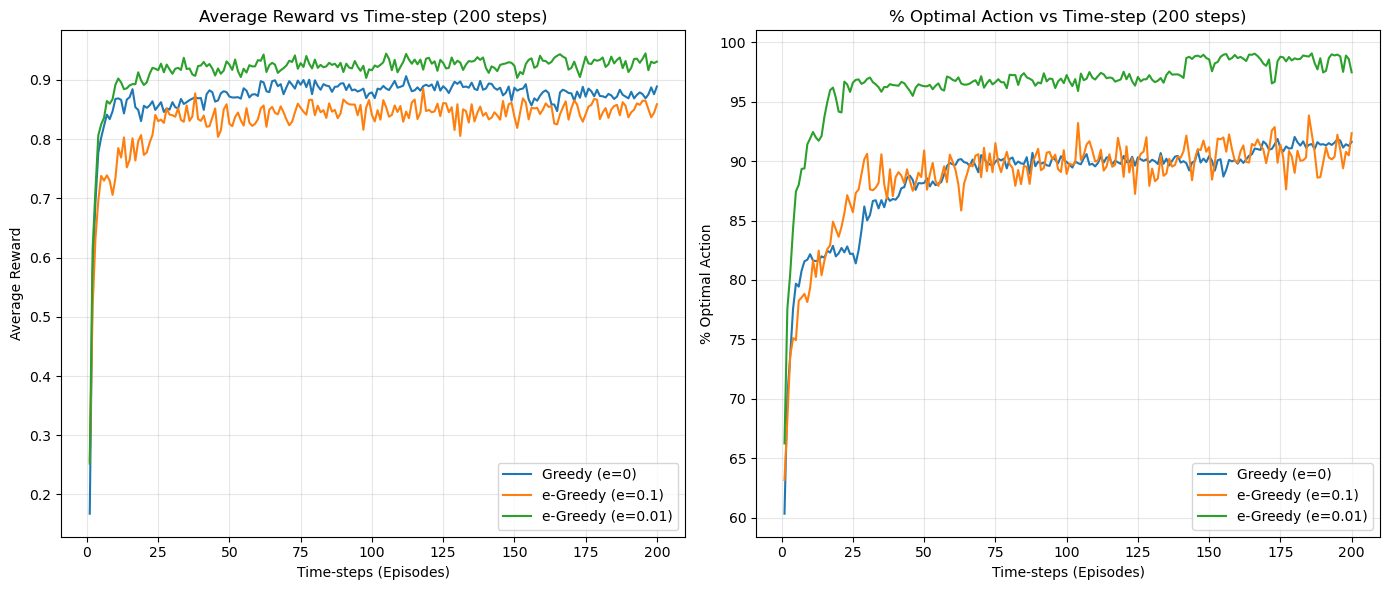


Starting Experiment: 400 Time-steps
Running for epsilon=0 | Steps: 400 | Games/Step: 2000


Eps 0: 100%|██████████| 400/400 [05:20<00:00,  1.25it/s]


Running for epsilon=0.1 | Steps: 400 | Games/Step: 2000


Eps 0.1: 100%|██████████| 400/400 [04:45<00:00,  1.40it/s]


Running for epsilon=0.01 | Steps: 400 | Games/Step: 2000


Eps 0.01: 100%|██████████| 400/400 [04:41<00:00,  1.42it/s]


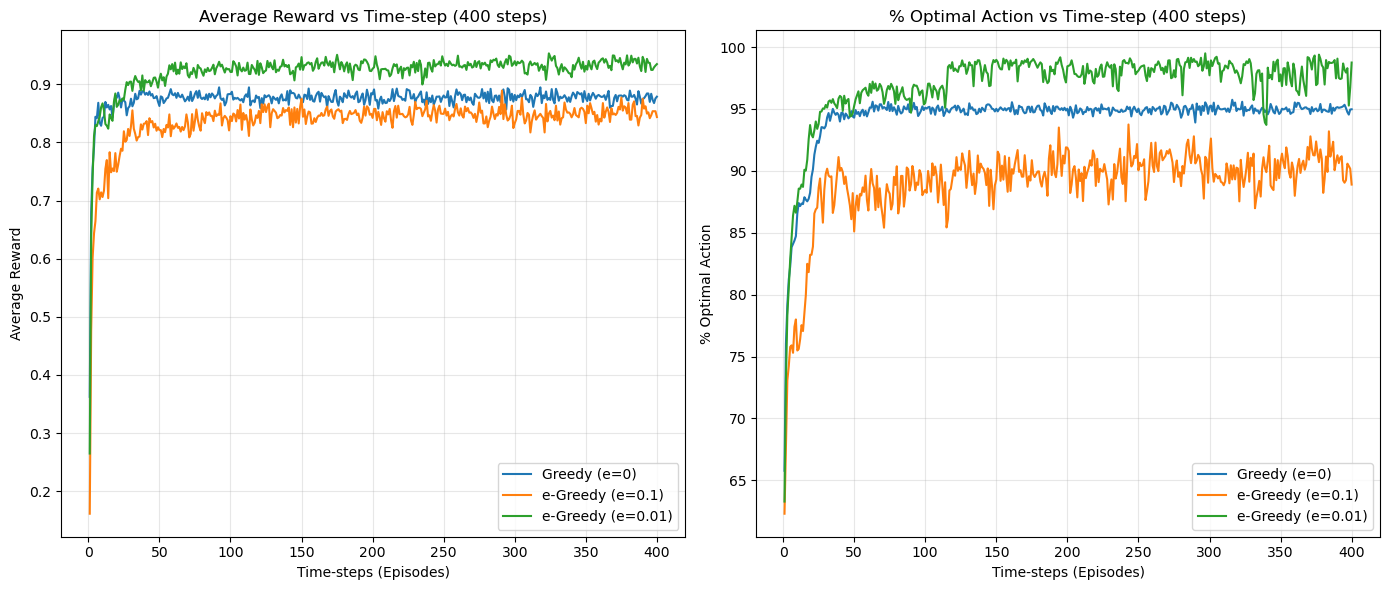

In [ ]:
class QLearningAgent:
    """
    This class is logically very similar to the 'Agent' class before, 
    but the 'learn' method signature is updated to be more explicit (passing state, action, next_state).
    """
    def __init__(self, epsilon=0.1, alpha=0.5, gamma=1.0):
        self.q_table = {} 
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        return self.q_table[state]
    
    def choose_action(self, state, available_actions):
        if np.random.random() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            q_values = self.get_q(state)
            mask_q = np.full(9, -np.inf)
            mask_q[available_actions] = q_values[available_actions]
            max_val = np.max(mask_q)
            # Break ties randomly
            best_actions = np.where(mask_q == max_val)[0]
            return np.random.choice(best_actions)

    def learn(self, state, action, reward, next_state, done, available_actions_next):
        """
        Updates Q-value for a specific state-action pair.
        """
        # 1. Retrieve current Q-value
        q_values = self.get_q(state)
        old_val = q_values[action]
        
        # 2. Calculate Target Q-value
        if done:
            # If terminal state, target is just the immediate reward
            target = reward
        else:
            # If not terminal, we look ahead (Bootstrapping)
            q_values_next = self.get_q(next_state)
            if len(available_actions_next) == 0:
                target = reward
            else:
                # Bellman Equation part: gamma * max(Q(next_state))
                max_q_next = np.max(q_values_next[available_actions_next])
                target = reward + self.gamma * max_q_next
        
        # 3. Update Rule
        self.q_table[state][action] = old_val + self.alpha * (target - old_val)

def plot_results(results_rewards, results_optimal, n_timesteps):
    """
    Visualization helper function.
    Plots two graphs:
    1. Average Reward vs Episodes (How much the agent wins)
    2. % Optimal Action vs Episodes (How often the agent makes the perfect move)
    """
    x = np.arange(1, n_timesteps + 1)
    
    plt.figure(figsize=(14, 6))
    
    # Plot Average Reward
    plt.subplot(1, 2, 1)
    for eps, data in results_rewards.items():
        label = f'Greedy (e=0)' if eps == 0 else f'e-Greedy (e={eps})'
        plt.plot(x, data, label=label)
    plt.xlabel('Time-steps (Episodes)')
    plt.ylabel('Average Reward')
    plt.title(f'Average Reward vs Time-step ({n_timesteps} steps)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Plot % Optimal Action
    plt.subplot(1, 2, 2)
    for eps, data in results_optimal.items():
        label = f'Greedy (e=0)' if eps == 0 else f'e-Greedy (e={eps})'
        plt.plot(x, data, label=label)
    plt.xlabel('Time-steps (Episodes)')
    plt.ylabel('% Optimal Action')
    # plt.ylim(0, 100)
    plt.title(f'% Optimal Action vs Time-step ({n_timesteps} steps)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def run_experiment(n_timesteps, n_games_per_step, epsilons):
    """
    Simulation Loop (Method A).
    Structure:
    - Iterate Epsilon (Hyperparameter)
      - Create ONE Agent
      - Iterate Time-steps (e.g., 0 to 100)
        - In each Time-step, play 'n_games_per_step' games.
        - The Agent KEEPS LEARNING throughout this whole process.
        - We record the average reward of the games in that specific time-step.
    
    This structure effectively smooths the curve by averaging multiple games at each point in the agent's life.
    """
    results_rewards = {}
    results_optimal = {}

    for eps in epsilons:
        print(f"Running for epsilon={eps} | Steps: {n_timesteps} | Games/Step: {n_games_per_step}")
        
        # Single agent persists across all time-steps for this epsilon
        agent = QLearningAgent(epsilon=eps, alpha=0.5, gamma=1.0)
        
        avg_rewards_per_step = np.zeros(n_timesteps)
        avg_optimal_per_step = np.zeros(n_timesteps)
        
        # Outer loop: Time-steps
        for t in tqdm(range(n_timesteps), desc=f"Eps {eps}"):
            
            step_total_reward = 0
            step_optimal_moves = 0
            step_total_moves = 0
            
            # Inner loop: Runs (Games per time-step)
            for g in range(n_games_per_step):
                env = TicTacToe()
                state = env.reset()
                done = False
                
                # Determine Agent Role: X (1) or O (-1)
                agent_player = 1 if np.random.random() < 0.5 else -1
                
                # If Agent is O, Opponent (X) moves first
                if agent_player == -1:
                    avail = env.available_actions()
                    opp_action = np.random.choice(avail) # Random Opponent
                    state, _, done = env.step(opp_action, -agent_player)
                
                game_reward = 0
                
                while not done:
                    # Agent chooses action
                    avail = env.available_actions()
                    action = agent.choose_action(state, avail)
                    
                    # Check Optimality (Evaluate against Minimax Oracle)
                    opt_moves = get_optimal_actions(state, agent_player)
                    if action in opt_moves:
                        step_optimal_moves += 1
                    step_total_moves += 1
                    
                    # Environment Step
                    next_state, reward, done = env.step(action, agent_player)
                    
                    if not done:
                        # Opponent Turn (Random)
                        opp_avail = env.available_actions()
                        opp_action = np.random.choice(opp_avail)
                        next_state, opp_reward, done = env.step(opp_action, -agent_player)
                        
                        if done:
                            if opp_reward == 1: # Opponent won
                                reward = -1
                            else:
                                reward = 0
                    
                    # Agent Learns from the transition
                    next_avail = env.available_actions() if not done else []
                    agent.learn(state, action, reward, next_state, done, next_avail)
                    
                    state = next_state
                    if done:
                        game_reward = reward
                
                step_total_reward += game_reward

            # Average for this time-step
            avg_rewards_per_step[t] = step_total_reward / n_games_per_step
            if step_total_moves > 0:
                avg_optimal_per_step[t] = (step_optimal_moves / step_total_moves) * 100.0
            else:
                avg_optimal_per_step[t] = 0
                    
        results_rewards[eps] = avg_rewards_per_step
        results_optimal[eps] = avg_optimal_per_step
        
    return results_rewards, results_optimal

# --------------------------
# Main Execution Blocks (Method A)
# --------------------------

# Configuration
# n_runs here is now "Games per Step"
RUNS = 2000 
EPSILONS = [0, 0.1, 0.01]
STEPS_LIST = [100, 200, 400]

for steps in STEPS_LIST:
    print(f"\nStarting Experiment: {steps} Time-steps")
    # Note: plotting is commented out or relied on previous definitions
    res_rew, res_opt = run_experiment(steps, RUNS, EPSILONS) 
    plot_results(res_rew, res_opt, steps)



Starting Experiment: 100 Time-steps
Running for epsilon=0 | Runs: 2000 | Steps: 100


Eps 0: 100%|██████████| 2000/2000 [01:29<00:00, 22.35it/s]


Running for epsilon=0.1 | Runs: 2000 | Steps: 100


Eps 0.1: 100%|██████████| 2000/2000 [01:28<00:00, 22.65it/s]


Running for epsilon=0.01 | Runs: 2000 | Steps: 100


Eps 0.01: 100%|██████████| 2000/2000 [01:29<00:00, 22.37it/s]


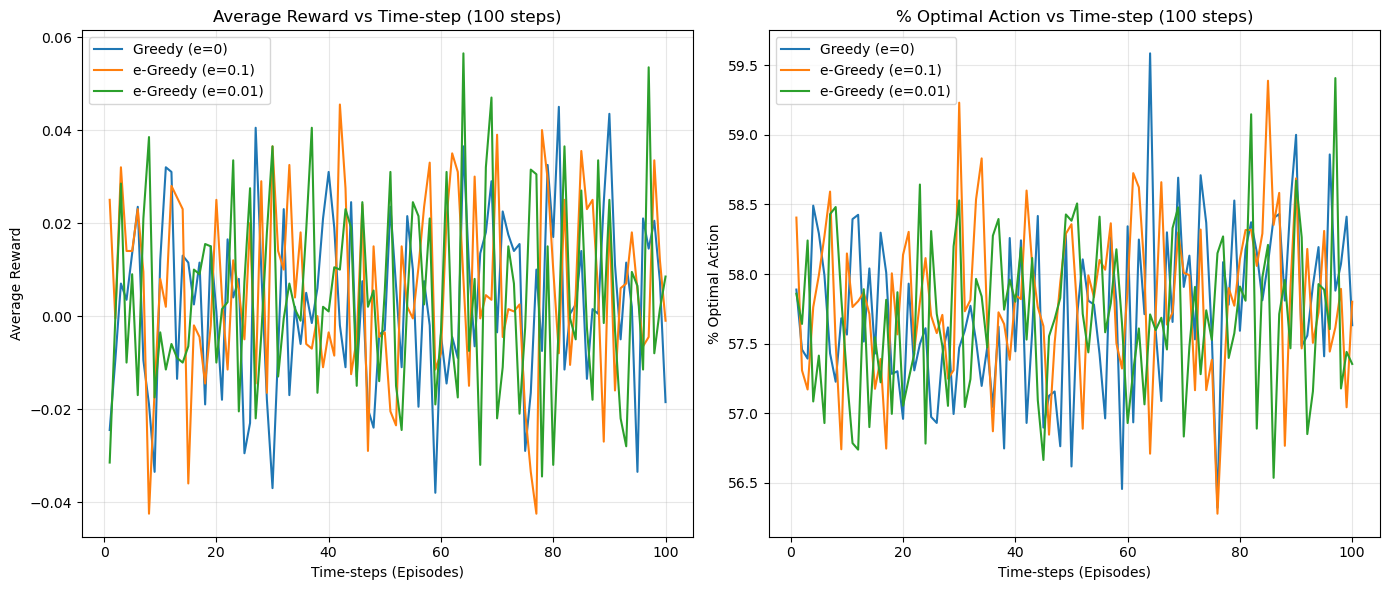


Starting Experiment: 200 Time-steps
Running for epsilon=0 | Runs: 2000 | Steps: 200


Eps 0: 100%|██████████| 2000/2000 [02:51<00:00, 11.68it/s]


Running for epsilon=0.1 | Runs: 2000 | Steps: 200


Eps 0.1: 100%|██████████| 2000/2000 [02:49<00:00, 11.77it/s]


Running for epsilon=0.01 | Runs: 2000 | Steps: 200


Eps 0.01: 100%|██████████| 2000/2000 [02:50<00:00, 11.74it/s]


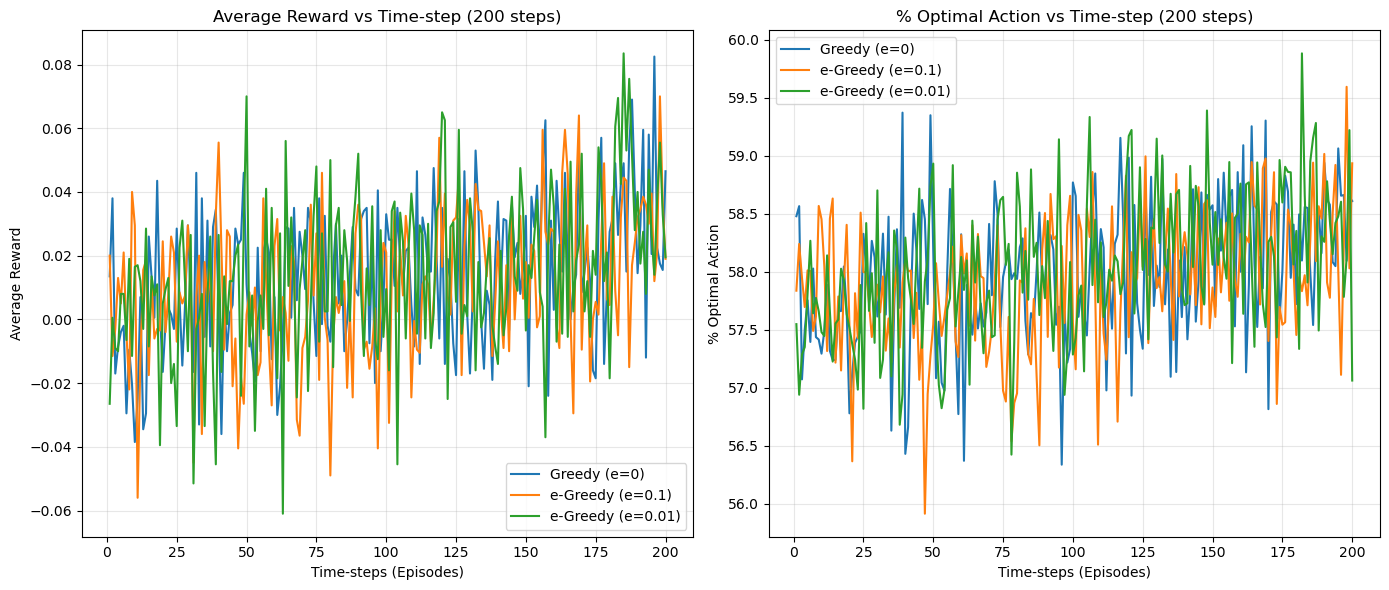


Starting Experiment: 400 Time-steps
Running for epsilon=0 | Runs: 2000 | Steps: 400


Eps 0: 100%|██████████| 2000/2000 [05:40<00:00,  5.88it/s]


Running for epsilon=0.1 | Runs: 2000 | Steps: 400


Eps 0.1: 100%|██████████| 2000/2000 [05:37<00:00,  5.92it/s]


Running for epsilon=0.01 | Runs: 2000 | Steps: 400


Eps 0.01: 100%|██████████| 2000/2000 [05:40<00:00,  5.88it/s]


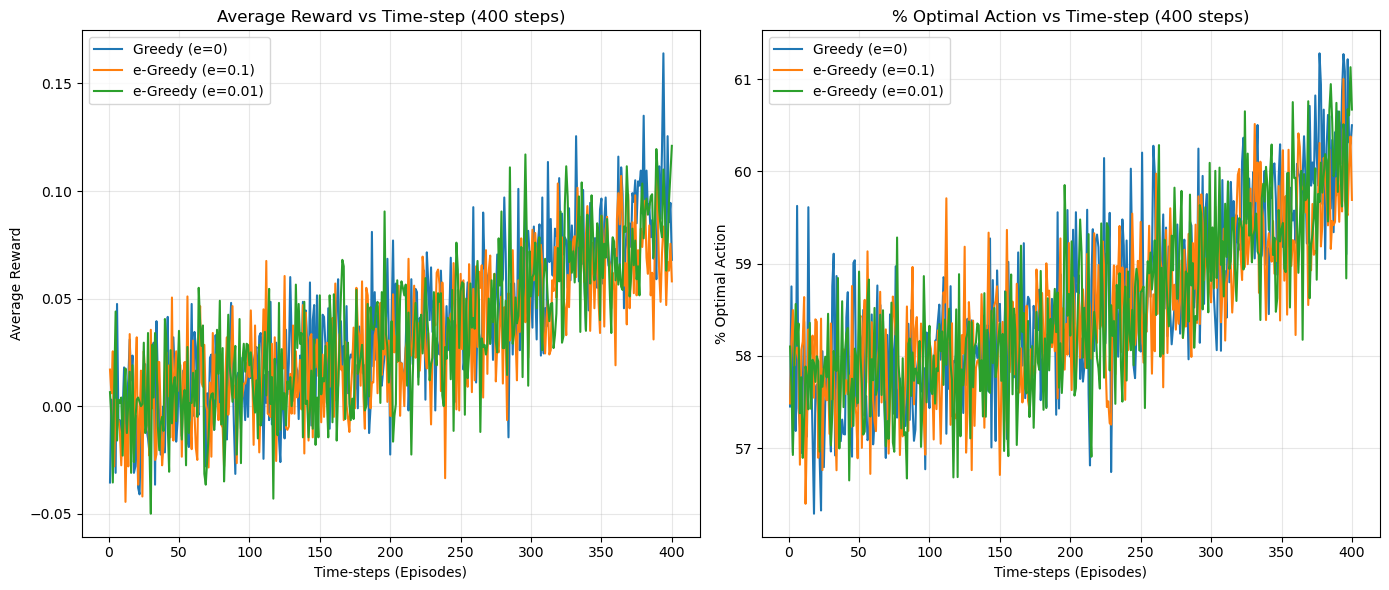

In [ ]:
# --------------------------
# Main Simulation Loop
# --------------------------

# Re-defining the agent class here to be self-contained within the experiment block logic 
# and slightly refined for the loop structure below.
class QLearningAgent:
    def __init__(self, epsilon=0.1, alpha=0.5, gamma=1.0):
        self.q_table = {} 
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        
    def get_q(self, state):
        if state not in self.q_table:
            self.q_table[state] = np.zeros(9)
        return self.q_table[state]
    
    def choose_action(self, state, available_actions):
        # Decide: Explore vs Exploit
        if np.random.random() < self.epsilon:
            return np.random.choice(available_actions)
        else:
            q_values = self.get_q(state)
            mask_q = np.full(9, -np.inf)
            mask_q[available_actions] = q_values[available_actions]
            max_val = np.max(mask_q)
            best_actions = np.where(mask_q == max_val)[0]
            return np.random.choice(best_actions)

    def learn(self, state, action, reward, next_state, done, available_actions_next):
        # Slightly different learn signature here allowing explicit state/next_state passing
        # which is easier for the loop below.
        
        q_values = self.get_q(state)
        old_val = q_values[action]
        
        if done:
            target = reward # No future if game over
        else:
            q_values_next = self.get_q(next_state)
            if len(available_actions_next) == 0: # Check just in case
                target = reward
            else:
                max_q_next = np.max(q_values_next[available_actions_next])
                target = reward + self.gamma * max_q_next
        
        self.q_table[state][action] = old_val + self.alpha * (target - old_val)

def run_experiment(n_timesteps, n_runs, epsilons):
    """
    Runs the full experiment.
    
    I want to generate learning curves. 
    Because RL is noisy (due to random exploration and random opponent moves),
    I will run `n_runs` INDEPENDENT agents for the same experiment and average their results.
    
    n_timesteps: How many episodes (games) each agent plays.
    n_runs: How many separate agents I train to get the average.
    """
    results_rewards = {}
    results_optimal = {}

    for eps in epsilons:
        print(f"Running for epsilon={eps} | Runs: {n_runs} | Steps: {n_timesteps}")
        
        # Arrays to accumulate stats across all runs
        total_rewards = np.zeros(n_timesteps)
        total_optimal = np.zeros(n_timesteps)
        
        for r in tqdm(range(n_runs), desc=f"Eps {eps}"):
            # Create a brand new naive agent for this run
            agent = QLearningAgent(epsilon=eps, alpha=0.5, gamma=1.0)
            
            for t in range(n_timesteps):
                env = TicTacToe()
                state = env.reset()
                done = False
                
                # Randomize who goes first to make the agent robust.
                # 1 = Agent (X), -1 = Opponent (O)
                agent_player = 1 if np.random.random() < 0.5 else -1
                
                # If Agent is O, the Opponent (Random) makes the first move
                if agent_player == -1:
                    avail = env.available_actions()
                    opp_action = np.random.choice(avail)
                    state, _, done = env.step(opp_action, -agent_player)
                
                # Tracking variables for this single game
                steps_in_game = 0
                optimal_steps = 0
                game_reward = 0
                
                while not done:
                    # 1. Agent decides
                    avail = env.available_actions()
                    action = agent.choose_action(state, avail)
                    
                    # 2. Metric: Is this move optimal?
                    # Check against our Minimax Oracle
                    opt_moves = get_optimal_actions(state, agent_player)
                    if action in opt_moves:
                        optimal_steps += 1
                    steps_in_game += 1
                    
                    # 3. Step Environment
                    next_state, reward, done = env.step(action, agent_player)
                    
                    if not done:
                        # 4. Opponent returns fire (Randomly)
                        opp_avail = env.available_actions()
                        opp_action = np.random.choice(opp_avail)
                        next_state, opp_reward, done = env.step(opp_action, -agent_player)
                        
                        # If opponent won, our reward is -1
                        if done:
                            if opp_reward == 1: 
                                reward = -1
                            else:
                                reward = 0
                    
                    # 5. Agent Learns
                    next_avail = env.available_actions() if not done else []
                    agent.learn(state, action, reward, next_state, done, next_avail)
                    
                    state = next_state
                    if done:
                        game_reward = reward
                
                # Record stats for this episode 't'
                total_rewards[t] += game_reward
                if steps_in_game > 0:
                    total_optimal[t] += (optimal_steps / steps_in_game) * 100.0
                else:
                    # Edge case: if game ended before agent moved (impossible usually)
                    total_optimal[t] += 100.0
                    
        # Compute averages
        results_rewards[eps] = total_rewards / n_runs
        results_optimal[eps] = total_optimal / n_runs
        
    return results_rewards, results_optimal

# --------------------------
# Execute & Plot
# --------------------------

RUNS = 2000 
EPSILONS = [0, 0.1, 0.01]
STEPS_LIST = [100, 200, 400]

for steps in STEPS_LIST:
    print(f"\nStarting Experiment: {steps} Time-steps")
    # I'll store the results and plot them using the function (assumed defined previously)
    res_rew, res_opt = run_experiment(steps, RUNS, EPSILONS)
    plot_results(res_rew, res_opt, steps) # Plotting helper from earlier cell


Starting Experiment: 800 Time-steps
Running for epsilon=0 | Runs: 2000 | Steps: 800


Eps 0: 100%|██████████| 2000/2000 [10:47<00:00,  3.09it/s]


Running for epsilon=0.1 | Runs: 2000 | Steps: 800


Eps 0.1: 100%|██████████| 2000/2000 [10:43<00:00,  3.11it/s]


Running for epsilon=0.01 | Runs: 2000 | Steps: 800


Eps 0.01: 100%|██████████| 2000/2000 [10:47<00:00,  3.09it/s]


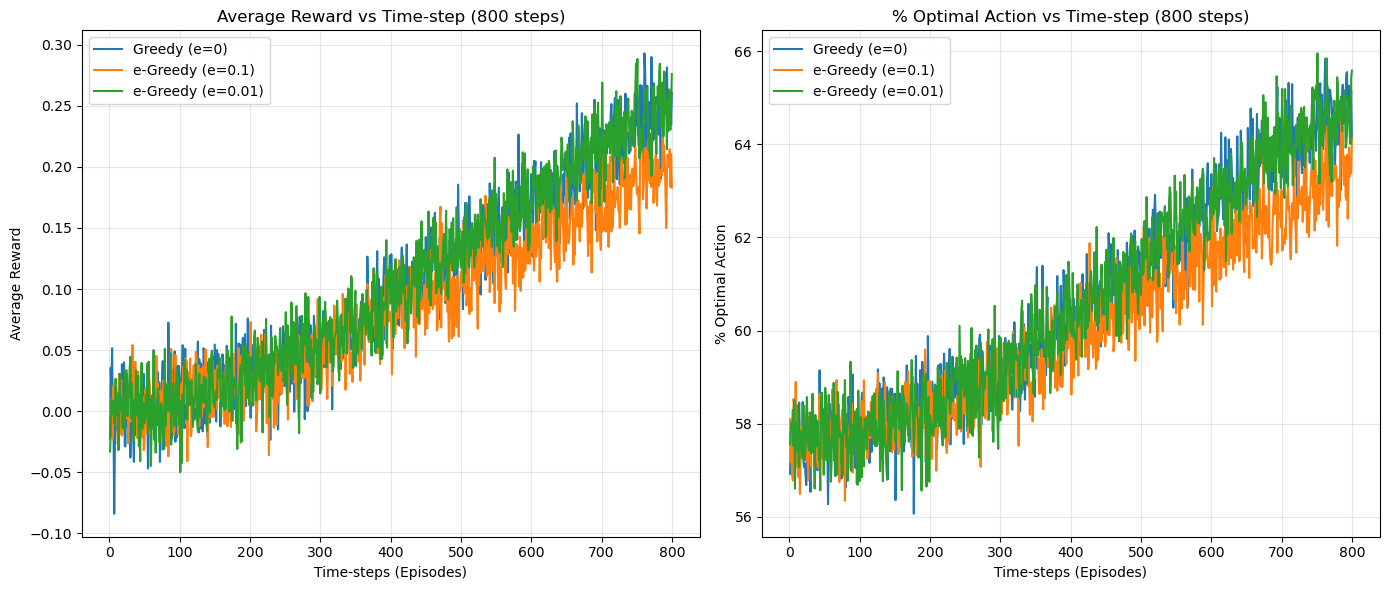

In [ ]:
# --------------------------
# Experiment 2: Longer Training
# --------------------------
# Training for 800 episodes to see if convergence improves.

RUNS = 2000 
EPSILONS = [0, 0.1, 0.01]
STEPS_LIST = [800] # Increased steps

for steps in STEPS_LIST:
    print(f"\nStarting Experiment: {steps} Time-steps")
    res_rew, res_opt = run_experiment(steps, RUNS, EPSILONS)
    plot_results(res_rew, res_opt, steps)



Starting Experiment: 2000 Time-steps
Running for epsilon=0 | Runs: 2000 | Steps: 2000


Eps 0: 100%|██████████| 2000/2000 [25:10<00:00,  1.32it/s]


Running for epsilon=0.1 | Runs: 2000 | Steps: 2000


Eps 0.1: 100%|██████████| 2000/2000 [25:10<00:00,  1.32it/s]


Running for epsilon=0.01 | Runs: 2000 | Steps: 2000


Eps 0.01: 100%|██████████| 2000/2000 [25:07<00:00,  1.33it/s]


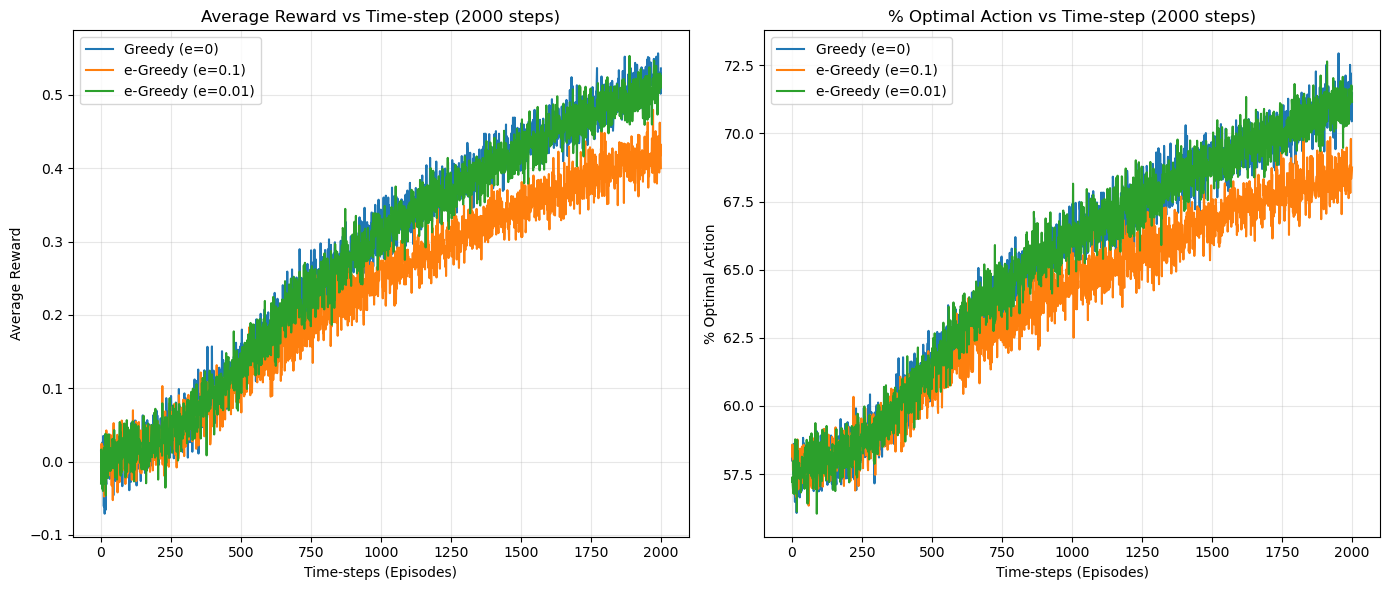

In [ ]:
# --------------------------
# Experiment 3: Very Long Training (2000 steps)
# --------------------------

RUNS = 2000 
EPSILONS = [0, 0.1, 0.01]
STEPS_LIST = [2000]

for steps in STEPS_LIST:
    print(f"\nStarting Experiment: {steps} Time-steps")
    res_rew, res_opt = run_experiment(steps, RUNS, EPSILONS)
    plot_results(res_rew, res_opt, steps)



Starting Experiment: 2000 Time-steps
Running for epsilon=0 | Runs: 4000 | Steps: 2000


Eps 0: 100%|██████████| 4000/4000 [50:24<00:00,  1.32it/s]


Running for epsilon=0.1 | Runs: 4000 | Steps: 2000


Eps 0.1: 100%|██████████| 4000/4000 [50:28<00:00,  1.32it/s]


Running for epsilon=0.01 | Runs: 4000 | Steps: 2000


Eps 0.01: 100%|██████████| 4000/4000 [50:18<00:00,  1.33it/s]


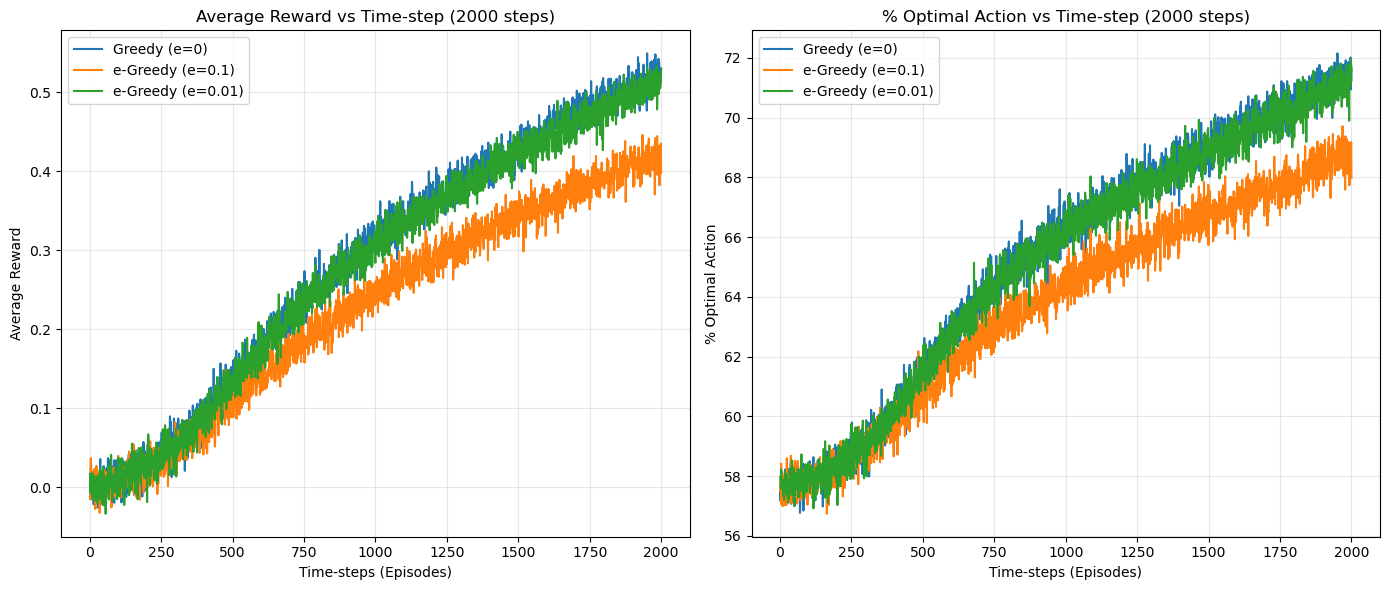

In [ ]:
# --------------------------
# Experiment 4: High Variance Check (4000 Runs)
# --------------------------
# Doubling the number of runs to get an even smoother curve.

RUNS = 4000 
EPSILONS = [0, 0.1, 0.01]
STEPS_LIST = [2000]

for steps in STEPS_LIST:
    print(f"\nStarting Experiment: {steps} Time-steps")
    res_rew, res_opt = run_experiment(steps, RUNS, EPSILONS)
    plot_results(res_rew, res_opt, steps)
